In [260]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import math
import pandas as pd
%matplotlib inline
%pylab inline 
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [266]:
#Input do modelo

t=9 #tempo de propagacao
r=0.065 #custo do capital
vol=0.3626 #volatilidade de preço por ano
delta_t=1 #um ano

P0=66 #preço do barril de petroleo inicial
u=math.exp(vol*math.sqrt(delta_t))  #subida de P
d=1/u #variação do preço negativa sendo o inverso da positiva
n=10 #fator de produção. Será substituido por uma curva de produção


vol_B=0.5

B_n0=400 #Reserva Inicial
s=math.exp(vol_B*math.sqrt(delta_t)) #subida do investimento 
ins=1/s #variação negotiva sendo o inverso da subida do investimento



In [267]:
#Ativos de Arrow Debreu: Medida de não arbitragem ponderado por 1+r

#Matriz
#U=np.array([[math.pow(u,2),math.pow(u,2),1,1],[math.pow(s,2),1,math.pow(s,2),1],[math.pow(u,2),math.pow((u*s),2),1,math.pow(s,2)],[1,1,1,1]])
U=np.array([[math.pow(u,2),math.pow(u,2),1,1],[math.pow(s,2),1,math.pow(s,2),1],[math.pow(u*s,2),math.pow(u,2),math.pow(s,2),1],[1,1,1,1]])
#vetor A
A=np.array([[u],[s],[(u*s)],[(1/(1+r))]])


#Inversão
phi=np.linalg.solve(U,A)
phi_us=phi[0,0]
phi_ui=phi[1,0]
phi_ds=phi[2,0]
phi_di=phi[3,0]

phi

array([[ 0.12156906],
       [ 0.34606137],
       [ 0.29149131],
       [ 0.1798454 ]])

In [268]:
#Propagar Preços, Investimentos e VPL

m= np.array([[1,0,1,0],[1,0,0,1],[0,1,1,0],[0,1,0,1]], dtype='int64') #matriz base para propagação no tempo
V = np.zeros((pow(4,t),4)) # tamanho da matriz, a cada tempo t, das potencias a ser propagada
#V=np.zeros((pow(4,1),4),dtype='int64') # tamanho da matriz, em t=1, das potencias a ser propagada, em inteiros
P=np.zeros((pow(4,t),(t+1))) #matriz completa com zeros de P
P[0,0]=P0 #P0 na cela 0,0
B_n=np.zeros((pow(4,t),(t+1))) #matriz completa com zeros de I
B_n[0,0]=B_n0 # IO na cela 0,0
VPL=np.zeros((pow(4,t),(t+1))) #matriz completa com zeros de VPL

In [269]:
#Função de Produção Entrada Preço e B_n

def VP(P,B_n):
    tempo= 25 #anos de produção
    #Premissas Economicas
    depr=0.7 #Investimento deprecivavel
    adepr=15 #anos de depreciacao
    #Curva S
    a1_s=0.093 #porcentagem
    a2_s=0.532
    a3_s=1- a1_s - a2_s  #soma deve ser igual a 1



    roy=0.1 #royalties
    tax= 0.34 #porcentagem do leao - imposto de renda

    #custo de abandono


    #taxa de desconto e retorno sem risco

    mi=0.1 #retorno total do ativo - pode ser retirado de ações
    r= 0.065 #r antes dos impostos

    # Equity e Divida
    e_por=0.7
    d_por= 1 - e_por #soma deve dar um


    tx_desc=(r*(1-tax)*d_por) + (mi*e_por) #Custo Médio Ponderado do Capital
    #tx_desc=0.1

    delta=r*(1-tax) #taxa de dividendos


    alpha_a=0.015

    
    
    
    
    cb=['Anos','Desconto','Producao_m','LN','Inv_t_m','Inv_ndep_m', 'Depr_m','Preco_m','PDQ_m','Receita_m','C_OP_Var_m','C_OP_Fixo_m',
    'Royalties_m','Abandono_m','FCT_m','Imposto_m', 'FCL_m']
    df=pd.DataFrame(index=range(1,tempo+4),columns=cb) #index 2 anos p producao e 1 de abandono
    df.Anos=df.index +2013 #ano de inicio
    df.Desconto=np.exp((-tx_desc)*(df.index-1))



    #parametro Q - PRODUCAO - OLEO RECUPERADO
    #Q=df.Producao.sum()
    Q=B_n*((math.pow(10,6))/(365))
    sigma=0.91
    media=2.5

    #0.91 / 2.5  valor encontrado para o modelo
    
    
    
    #Produção MODELADA
    df.loc[1,'LN']=(1/(0.1*sigma*np.sqrt(2*np.pi)))*np.exp(-1*(np.power(((np.log(0.01))-media),2))/(2*np.power(sigma,2)))
    for i in range(3,len(df)):
        df.loc[i,'LN']=(1/((i-1*sigma*np.sqrt(2*np.pi)))*np.exp(-1*(np.power(((np.log(i-1))-media),2))/(2*np.power(sigma,2))))

    df.Producao_m=(1/(df.LN.sum()))*Q*df.LN


    #Investimento _MODELADO
    #Investimento em Milhoes
    Inv_t_m= 7.1229*(B_n) + 4956.6
    #Inv_t_m= (4*math.pow(10,-7))*(math.pow(B_n,3)) -(0.0049)*np.power(B_n/1000,2)+ (22.936*B_n) -1543.4
    #Investimento Total MODELADO
    df.loc[1,'Inv_t_m']=Inv_t_m*a1_s
    df.loc[2,'Inv_t_m']=Inv_t_m*a2_s
    df.loc[3,'Inv_t_m']=Inv_t_m*a3_s

    #Investimento Nao Depreciavel MODELADO
    df.loc[1,'Inv_ndep_m']=Inv_t_m*a1_s*(1-depr)
    df.loc[2,'Inv_ndep_m']=Inv_t_m*a2_s*(1-depr)
    df.loc[3,'Inv_ndep_m']=Inv_t_m*a3_s*(1-depr)

    #Depreciação MODELADO
    df.loc[3:adepr+1,'Depr_m']= Inv_t_m*depr/adepr


    #Preço do Barril +A MODELAR

    df.loc[1,'Preco_m']=P
    for anos in range(2,tempo+4):
        df.loc[anos,'Preco_m']=P*np.exp(alpha_a*anos)
    #P_t D_t Q_t MODELADO

    df.PDQ_m=df.Producao_m*df.Desconto*df.Preco_m


    #Receita Milhoes dolares/ano MODELADO

    df.Receita_m=(df.Producao_m*df.Preco_m)*365/(math.pow(10,6))

    #Custo operacional Variavel milhoes de dolares/anos MODELADO
    coV_m= (1*math.pow(10,-7))*(math.pow(B_n,2)) -(0.0018)*(B_n)+10.162
    df.C_OP_Var_m=(df.Producao_m*coV_m)*365/(math.pow(10,6))

    #Custo Fixo milhoes de dolares/anos MODELADO
    #coF_m= (1*math.pow(10,-5))*(math.pow(B_n,2)) +(0.1642)*(B_n)+59.43
    coF_m= 0.0909*(B_n) + 104.46
    df.C_OP_Fixo_m=np.where(df.Producao_m>0.5,coF_m,0)

    #Royalties milhoes de dolares/ano MODELADO
    df.Royalties_m=df.Receita_m*roy

    #Abandono MODELADO
    #abondo_m= (7*math.pow(10,-8))*(math.pow(B_n,3)) -(0.001)*np.power(B_n,2)+ (4.5029*B_n) -176.1
    abondo_m= 1.5295*(B_n) + 1019.1
    #abondo_m=0
    df.loc[tempo+3,'Abandono_m']=abondo_m

    #fillnan
    df= df.fillna(0)

    #Fluxo de Caixa Tributavel milhoes ano MODEALDO
    df.FCT_m= df.Receita_m - df.Inv_ndep_m -df.Depr_m - df.C_OP_Var_m  -df.C_OP_Fixo_m - df.Royalties_m - df.Abandono_m

    #Imposto de Renda milhoes ano MODELADO
    df.Imposto_m=df.FCT_m*tax

    #Fluxo de Caixa Liquido MODELADO

    df.FCL_m= df.FCT_m + df.Depr_m -df.Imposto_m  -(df.Inv_t_m- df.Inv_ndep_m)

    #VPL MODELADO
    VPL_m=(df.FCL_m*df.Desconto).sum()

    #Investimento a tempo presente MODELADO

    I_t0_m=((df.Inv_t_m*df.Desconto)-(tax*(df.Inv_ndep_m*df.Desconto))-(tax*(df.Depr_m*df.Desconto))+((1-tax)*(df.Abandono_m*df.Desconto))).sum()

    #Valor Presente MODELADO
    V_t0_m= VPL_m+I_t0_m


    #Razao V_to/I_to MODELADO

    V_I=V_t0_m/I_t0_m


    #Reserva em milhoes de barris
    B_m=(df.Producao_m*(365)/(math.pow(10,6))).sum()


    #modelo Paramétrico de VPL VPL=qBP -I
    q_m=V_t0_m/(B_m*df.Preco_m.mean())

    #Break even
    breven_m=I_t0_m/(q_m*B_m)
    
    return VPL_m





In [270]:
VPL=np.zeros((pow(4,t),(t+1))) #matriz completa com zeros de VPL
VPL[0,0]= max(VP(P[0,0],B_n[0,0]),0)



for t0 in range (t):
    Vlast=V
    V=np.zeros((pow(4,t0+1),4), dtype='int64')
    k=0
    i=0
    while k< pow(4,t0+1):
        i=i+1
        for j in range(4):
            V[k,:]=Vlast[i-1,:]+m[j,:]
            P[k,t0+1]=P0*pow(u,V[k,0])*pow(d,V[k,1]) #Calculo dos Preços Futuros
            B_n[k,t0+1]=B_n0*pow(s,V[k,2])*pow(ins,V[k,3]) #Calculo dos Investimentos Futuros 
            VPL[k,t0+1]= max(0,VP(P[k,t0+1],B_n[k,t0+1]))
            k=k+1

KeyboardInterrupt: 

In [ ]:
# Função Backwards Nesta Função Formamos a Opção no tempo e a Árvore de Decisao
F=np.zeros((pow(4,t),(t+1))) # A opção no tempo
F[:]=np.NaN
D=np.zeros((pow(4,t),(t+1)))  #Árvore de Decisao
D[:]=np.NaN
for i in range(pow(4,t)):  #O valor da opção em t=T é o valor do VPL calculado
    F[i,t]=VPL[i,t]
    if F[i,t] >0:
        D[i,t]=1 #Decisao de Investir
    else:
        D[i,t]=-1 #Decisao de Nao Investir
    

for j in range (t,0,-1): #o valor da opções em t<T é o máximo entre o VPL calculado e a opção deste ramo
    for i in range(pow(4,j-1)):
        F[i,j-1]=max (VPL[i,j-1],phi_us*F[(4*i),j]+ phi_ui*F[(4*i)+1,j]+phi_ds*F[(4*i)+2,j]+ phi_di*F[(4*i)+3,j])
        if F[i,j-1] == VPL[i,j-1] and VPL[i,j-1]!=0:
            D[i,j-1]=1 #Decisao 1 de Não Investir
        else:
            D[i,j-1]=0 #Decisao 0 de Esperar
        
        

In [ ]:
#Ajeitar a arvore de Decisao

for j in range(t):
    for i in range(pow(4,j)):
        if D[i,j]==1 or D[i,j]==np.NaN:
            D[(4*i),j+1]=np.NaN
            D[(4*i)+1,j+1]=np.NaN
            D[(4*i)+2,j+1]=np.NaN
            D[(4*i)+3,j+1]=np.NaN

In [ ]:
# Criação do alinhamento das amostras Preco
PA=np.zeros((pow(4,t),(t+1)))  
PA[:]=np.NaN
PA[:,t]=P[:,t]
for j in range(t,0,-1):
    for i in range(pow(4,j-1)):
        if i==0:
            PA[int((pow(4,t-(j-1)))/2)-1,j-1]=P[i,j-1]
        else:
            PA[int(i*(pow(4,t-(j-1)))+((pow(4,t-(j-1)))/2)-1),j-1]=P[i,j-1]

In [ ]:
# Criação do alinhamento das amostras B_n
B_nA=np.zeros((pow(4,t),(t+1)))  
B_nA[:]=np.NaN
B_nA[:,t]=B_n[:,t]
for j in range(t,0,-1):
    for i in range(pow(4,j-1)):
        if i==0:
            B_nA[int((pow(4,t-(j-1)))/2)-1,j-1]=B_n[i,j-1]
        else:
            B_nA[int(i*(pow(4,t-(j-1)))+((pow(4,t-(j-1)))/2)-1),j-1]=B_n[i,j-1]

In [ ]:
# Criação do alinhamento das amostras VPL
VPLA=np.zeros((pow(4,t),(t+1)))  
VPLA[:]=np.NaN
VPLA[:,t]=VPL[:,t]
for j in range(t,0,-1):
    for i in range(pow(4,j-1)):
        if i==0:
            VPLA[int((pow(4,t-(j-1)))/2)-1,j-1]=VPL[i,j-1]
        else:
            VPLA[int(i*(pow(4,t-(j-1)))+((pow(4,t-(j-1)))/2)-1),j-1]=VPL[i,j-1]

In [ ]:
# Criação do alinhamento das amostras F
FA=np.zeros((pow(4,t),(t+1)))  
FA[:]=np.NaN
FA[:,t]=F[:,t]
for j in range(t,0,-1):
    for i in range(pow(4,j-1)):
        if i==0:
            FA[int((pow(4,t-(j-1)))/2)-1,j-1]=F[i,j-1]
        else:
            FA[int(i*(pow(4,t-(j-1)))+((pow(4,t-(j-1)))/2)-1),j-1]=F[i,j-1]

In [ ]:
# Criação do alinhamento das amostras Decisao
DA=np.zeros((pow(4,t),(t+1)))  
DA[:]=np.NaN
DA[:,t]=D[:,t]
for j in range(t,0,-1):
    for i in range(pow(4,j-1)):
        if i==0:
            DA[int((pow(4,t-(j-1)))/2)-1,j-1]=D[i,j-1]
        else:
            DA[int(i*(pow(4,t-(j-1)))+((pow(4,t-(j-1)))/2)-1),j-1]=D[i,j-1]

In [ ]:
print(D[0,0],"","","",F[0,0],"" ,"" , VPL[0,0])
imshow(DA,cmap='RdYlGn', aspect=0.0045,)  #Plot da Decisao
colorbar()

In [209]:
#OS PRECOS
Pdf=pd.DataFrame(PA)
#OS Volumes Recuperaveis
B_ndf=pd.DataFrame(B_nA)

In [210]:
#OS VPLs
VPLdf=pd.DataFrame(VPLA)
#AS Decisoes
Ddf=pd.DataFrame(DA)
#AS OPCOES
Fdf=pd.DataFrame(FA)


In [245]:
Ddf[Ddf.loc[:,0]==1]

,0,1,2,3,4,5


In [246]:
Ddf[Ddf.loc[:,1]==1]

,0,1,2,3,4,5


In [247]:
Ddf[Ddf.loc[:,2]==1]

,0,1,2,3,4,5


In [248]:
Ddf[Ddf.loc[:,3]==1]

,0,1,2,3,4,5


In [249]:
Ddf[Ddf.loc[:,3]==1]

,0,1,2,3,4,5


In [254]:
Ddf[Ddf.loc[:,4]==1]

,0,1,2,3,4,5
1,NaN,NaN,NaN,NaN,1.0,NaN
9,NaN,NaN,NaN,NaN,1.0,NaN
33,NaN,NaN,NaN,NaN,1.0,NaN
41,NaN,NaN,NaN,NaN,1.0,NaN
129,NaN,NaN,NaN,NaN,1.0,NaN
137,NaN,NaN,NaN,NaN,1.0,NaN
161,NaN,NaN,NaN,NaN,1.0,NaN
169,NaN,NaN,NaN,NaN,1.0,NaN
513,NaN,NaN,NaN,NaN,1.0,NaN
521,NaN,NaN,NaN,NaN,1.0,NaN


In [251]:
Pdf.loc[41,4], B_ndf.loc[41,4]

(66.000000000000014, 9813.0120788437434)

In [175]:
Pdf.loc[1,4], B_ndf.loc[1,4]

(281.47812673658865, 9813.0120788437434)

In [176]:
Pdf.loc[673,4], B_ndf.loc[673,4]

(31.959029106009531, 9813.0120788437434)

In [218]:
Pdf.loc[641,4], B_ndf.loc[641,4]

(66.000000000000014, 9813.0120788437434)

In [77]:
Ddf[Ddf.loc[:,5]==1]

,0,1,2,3,4,5
0,NaN,NaN,NaN,NaN,NaN,1.0
1,NaN,NaN,NaN,NaN,0.0,1.0
2,NaN,NaN,NaN,NaN,NaN,1.0
3,NaN,NaN,NaN,NaN,NaN,1.0
4,NaN,NaN,NaN,NaN,NaN,1.0
5,NaN,NaN,NaN,NaN,0.0,1.0
6,NaN,NaN,NaN,NaN,NaN,1.0
7,NaN,NaN,NaN,0.0,NaN,1.0
8,NaN,NaN,NaN,NaN,NaN,1.0
9,NaN,NaN,NaN,NaN,0.0,1.0


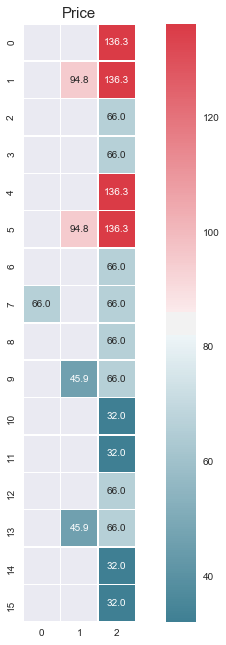

In [36]:
#OS PRECOS
plt.figure(figsize=(11,11))
plt.title('Price', size = 15)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(Pdf, annot=True, fmt=".1f", linewidths=.5, square = True, cmap =cmap)

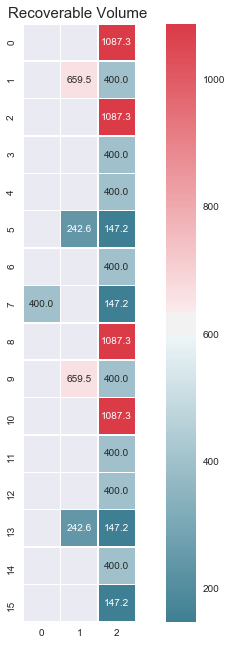

In [38]:
#OS Volumes Recuperaveis
plt.figure(figsize=(11,11))
plt.title('Recoverable Volume ', size = 15)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(B_ndf, annot=True, fmt=".1f", linewidths=.5, square = True, cmap =cmap);

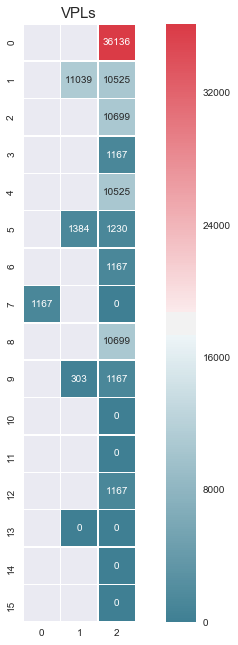

In [39]:
#OS VPLs
plt.figure(figsize=(11,11))
plt.title('VPLs', size = 15)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(VPLdf, annot=True, fmt=".0f", linewidths=.5, square = True, cmap =cmap);

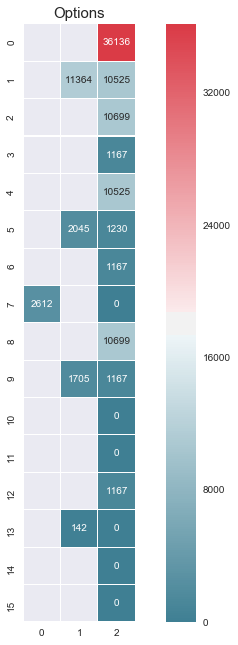

In [40]:
#AS OPCOES
plt.figure(figsize=(11,11))
plt.title('Options', size = 15)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(Fdf, annot=True, fmt=".0f", linewidths=.10, square = True, cmap =cmap);

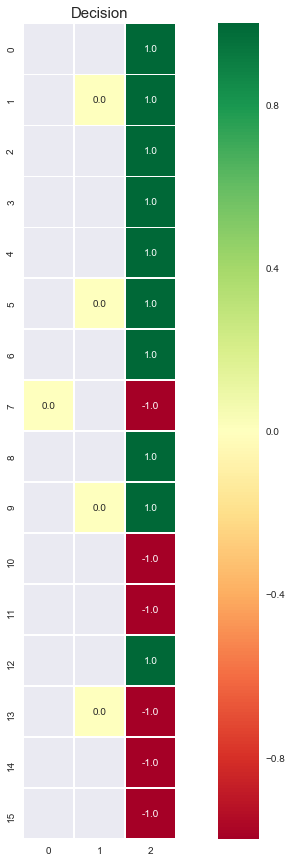

In [41]:
#AS Decisoes
plt.figure(figsize=(15,15))
plt.title('Decision', size = 15)
sns.heatmap(Ddf, annot=True, fmt=".1f", linewidths=.5, square = True,cmap ='RdYlGn');